# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x:'%.3f' % x)
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../testA.csv')
print(train.shape, test.shape)
train.head()

(800000, 47) (200000, 46)


,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.000,5,19.520,917.970,E,E2,320.000,2 years,2,110000.000,2,2014-07-01,1,1,137.000,32,17.050,0.000,730.000,734.000,7.000,0.000,0.000,24178.000,48.900,27.000,0,0,Aug-2001,1.000,1.000,0.000,2.000,2.000,2.000,4.000,9.000,8.000,4.000,12.000,2.000,7.000,0.000,0.000,0.000,2.000
1,1,18000.000,5,18.490,461.900,D,D2,219843.000,5 years,0,46000.000,2,2012-08-01,0,0,156.000,18,27.830,0.000,700.000,704.000,13.000,0.000,0.000,15096.000,38.900,18.000,1,0,May-2002,1723.000,1.000,nan,nan,nan,nan,10.000,nan,nan,nan,nan,nan,13.000,nan,nan,nan,nan
2,2,12000.000,5,16.990,298.170,D,D3,31698.000,8 years,0,74000.000,2,2015-10-01,0,0,337.000,14,22.770,0.000,675.000,679.000,11.000,0.000,0.000,4606.000,51.800,27.000,0,0,May-2006,0.000,1.000,0.000,0.000,3.000,3.000,0.000,0.000,21.000,4.000,5.000,3.000,11.000,0.000,0.000,0.000,4.000
3,3,11000.000,3,7.260,340.960,A,A4,46854.000,10+ years,1,118000.000,1,2015-08-01,0,4,148.000,11,17.210,0.000,685.000,689.000,9.000,0.000,0.000,9948.000,52.600,28.000,1,0,May-1999,4.000,1.000,6.000,4.000,6.000,6.000,4.000,16.000,4.000,7.000,21.000,6.000,9.000,0.000,0.000,0.000,1.000
4,4,3000.000,3,12.990,101.070,C,C2,54.000,NaN,1,29000.000,2,2016-03-01,0,10,301.000,21,32.160,0.000,690.000,694.000,12.000,0.000,0.000,2942.000,32.000,27.000,0,0,Aug-1977,11.000,1.000,1.000,2.000,7.000,7.000,2.000,4.000,9.000,10.000,15.000,7.000,12.000,0.000,0.000,0.000,4.000


In [3]:
# 样本的好坏比：大约4:1的比例
train['isDefault'].value_counts()

0    640390
1    159610
Name: isDefault, dtype: int64

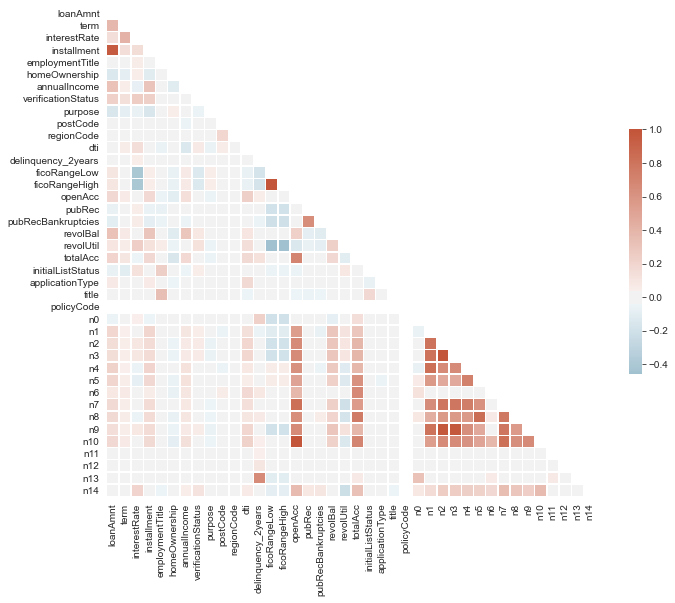

In [4]:
# 原始特征相关性热力图
sns.set_style(style="white")
corr = train.drop(['id', 'isDefault'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # mask上三角地区
f, ax = plt.subplots(figsize=(12, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # 自定义colormap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.show()

可以看出：

1. policeCode方差为0，可以直接删掉；
2. installment和loanAmnt相关性较高；
3. 部分高度相关的特征均为n系列字段（用户的贷后行为计数特征）；
4. ficoRangeLow和ficoRangeHigh特征高度相关，后续应删掉其中之一。

In [5]:
# 数值型特征
num_fea = list(train.select_dtypes(exclude=['object']).columns)

# 字符型特征
cat_fea = list(filter(lambda x: x not in num_fea, list(train.columns)))

# 原数据连续型特征
con_fea = ['loanAmnt', 'interestRate', 'installment', 'annualIncome', 'dti', 'ficoRangeLow', 'ficoRangeHigh', 'revolBal', 'revolUtil', 'totalAcc']

# 原数据分类型（离散型）特征
dis_fea = ['term', 'grade', 'subGrade', 'employmentLength', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode',\
           'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'pubRec', 'initialListStatus', 'applicationType']

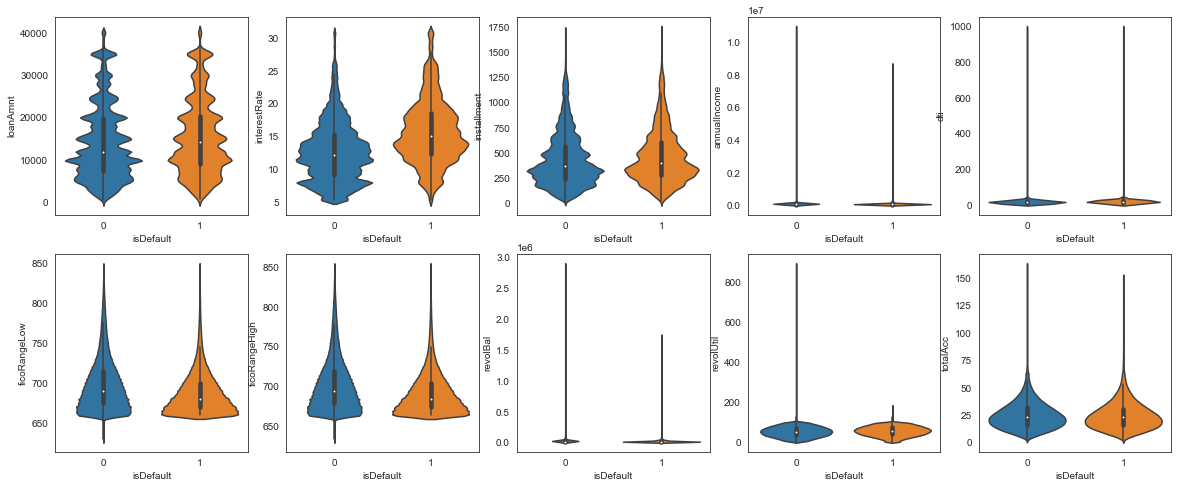

In [6]:
fig = plt.figure(figsize=(20,8))
nRows = 2
nCols = 5
nPlots = len(con_fea)  # 10
ax1 = fig.add_subplot(nRows, nCols, 1)

for i in range(1, nPlots+1):
    plt.subplot(nRows, nCols, i)
    sns.violinplot(x='isDefault', y=con_fea[i-1], data=train)

连续型单特征在训练集、测试集上的分布情况对比：
1. interestRate、ficoRangeLow、ficoRangeHigh在两个样本集上的分布差异较大，应重点关注；
2. ficoRangeLow和ficoRangeHigh的分布基本一样，再加上之前的相关性分析，二者corr接近1，仍考虑删掉其中之一，具体删掉哪个可以交给树模型来决定。

# 数据清洗

## 缺失值

在信贷领域，用户信息的完善程度可能会直接影响到该用户的信用评级。如一个信息完善程度为100%的用户比起50%的用户，会更加容易审核通过得到借款，且信息越完善的用户应该对自身的还款意识更强。

### 按列统计

In [7]:
def missing_value_table(df):
    """
    计算每个特征下样本缺失值个数及所占比例
    """
    mis_value = df.isnull().sum()  # 每个特征的缺失值个数
    mis_value_percent = 100 * mis_value / len(df)  # 每个特征的缺失值占比
    table = pd.concat([mis_value, mis_value_percent], axis=1)
    table.columns = ['缺失值个数', '缺失值占比']
    table = table.sort_values(by='缺失值占比', ascending=False).round(2)
    
    return table

In [8]:
missing_value_table(train)

,缺失值个数,缺失值占比
n11,69752,8.720
employmentLength,46799,5.850
n8,40271,5.030
n7,40270,5.030
n1,40270,5.030
n2,40270,5.030
n3,40270,5.030
n5,40270,5.030
n6,40270,5.030
n14,40270,5.030


In [9]:
missing_value_table(test)

,缺失值个数,缺失值占比
n11,17575,8.790
employmentLength,11742,5.870
n14,10111,5.060
n2,10111,5.060
n13,10111,5.060
n12,10111,5.060
n0,10111,5.060
n9,10111,5.060
n8,10111,5.060
n7,10111,5.060


可以看出：
1. 主要的缺失值集中在employmentLength和n系列匿名特征中。
2. 且所有特征缺失占比均小于10%，考虑填充法或者以缺失作为新类别

### 按行统计

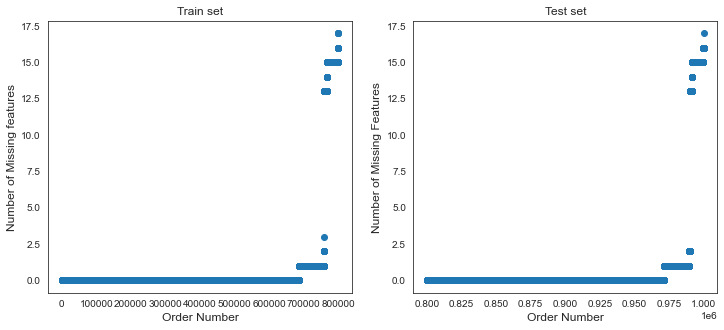

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.plot(train['id'].values, np.sort(train.isnull().sum(axis=1).values), 'o')
ax1.set_xlabel('Order Number', fontsize=12)
ax1.set_ylabel('Number of Missing features', fontsize=12)
ax1.set_title('Train set', fontsize=12)

ax2 = axes[1]
ax2.plot(test['id'].values, np.sort(test.isnull().sum(axis=1).values), 'o')
ax2.set_xlabel('Order Number', fontsize=12)
ax2.set_ylabel('Number of Missing Features', fontsize=12)
ax2.set_title('Test set', fontsize=12)
plt.show()

可以看出：
1. 很明显训练集和测试集上缺失值的行列分布情况基本相同，除了特征缺失数为3的样本，因此可以考虑去除；
2. 同时，训练集和测试集上同时含有10个特征缺失的样本，可以考虑删除（因为缺失值特征>3的情况都是比较离散的，即从缺失情况来看，这些样本与多数样本的‘距离’较远，可以认为是异常点）；
3. 针对第2点的方法，还可以考虑将样本的原始特征缺失个数作为一个新特征，表示用户的信息完善程度。

In [11]:
# 删掉缺失特征数为3的样本
train = train[train.isnull().sum(axis=1) != 3]

# 经检验后，这里选择的是新增特征的方法
# 新增一个特征：表示每个样本缺失的特征数
train['n_nulls'] = train.isnull().sum(axis=1).copy()
test['n_nulls'] = test.isnull().sum(axis=1).copy()

# -1代表一种新的类别：是否缺失
#cols_4fillna = ['employmentLength', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
#odel_train[cols_4fillna] = model_train[cols_4fillna].fillna(-1)
#model_test[cols_4fillna] = model_test[cols_4fillna].fillna(-1)

### 剔除低方差变量

In [12]:
# 剔除方差小于0.1的特征
train = train.drop(['applicationType', 'policyCode', 'n11', 'n12'], axis=1)
test = test.drop(['applicationType', 'policyCode', 'n11', 'n12'], axis=1)

### 剔除离群点

In [13]:
# 树模型得出feature importance，然后根据Top_k从大到小排序，判断样本在重要特征上的缺失情况，如果缺失过多就考虑删除样本

In [14]:
train = train.reset_index(drop=False)
test = test.reset_index(drop=False)

# 保存数据
train.to_csv('train_clean.csv', )